In [355]:
using Revise, Plots, FFTW, LinearAlgebra, LaTeXStrings, Random, Distributions

In [356]:
includet("../../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [357]:
domain = [0, 1]

x0 = [0.2, 0.35, 0.65]
a0 = [1.0, 1.0, -1.0]

μ0 = DiscreteMeasure(x0, a0)

DiscreteMeasure([0.2, 0.35, 0.65], [1.0, 1.0, -1.0], 1, 3)

In [358]:
# Define the number of Fourier coefficients
fc = 4
n = 2fc + 1

# Define noise level
noise_level = 0

# Seed for noise
Random.seed!(12)

TaskLocalRNG()

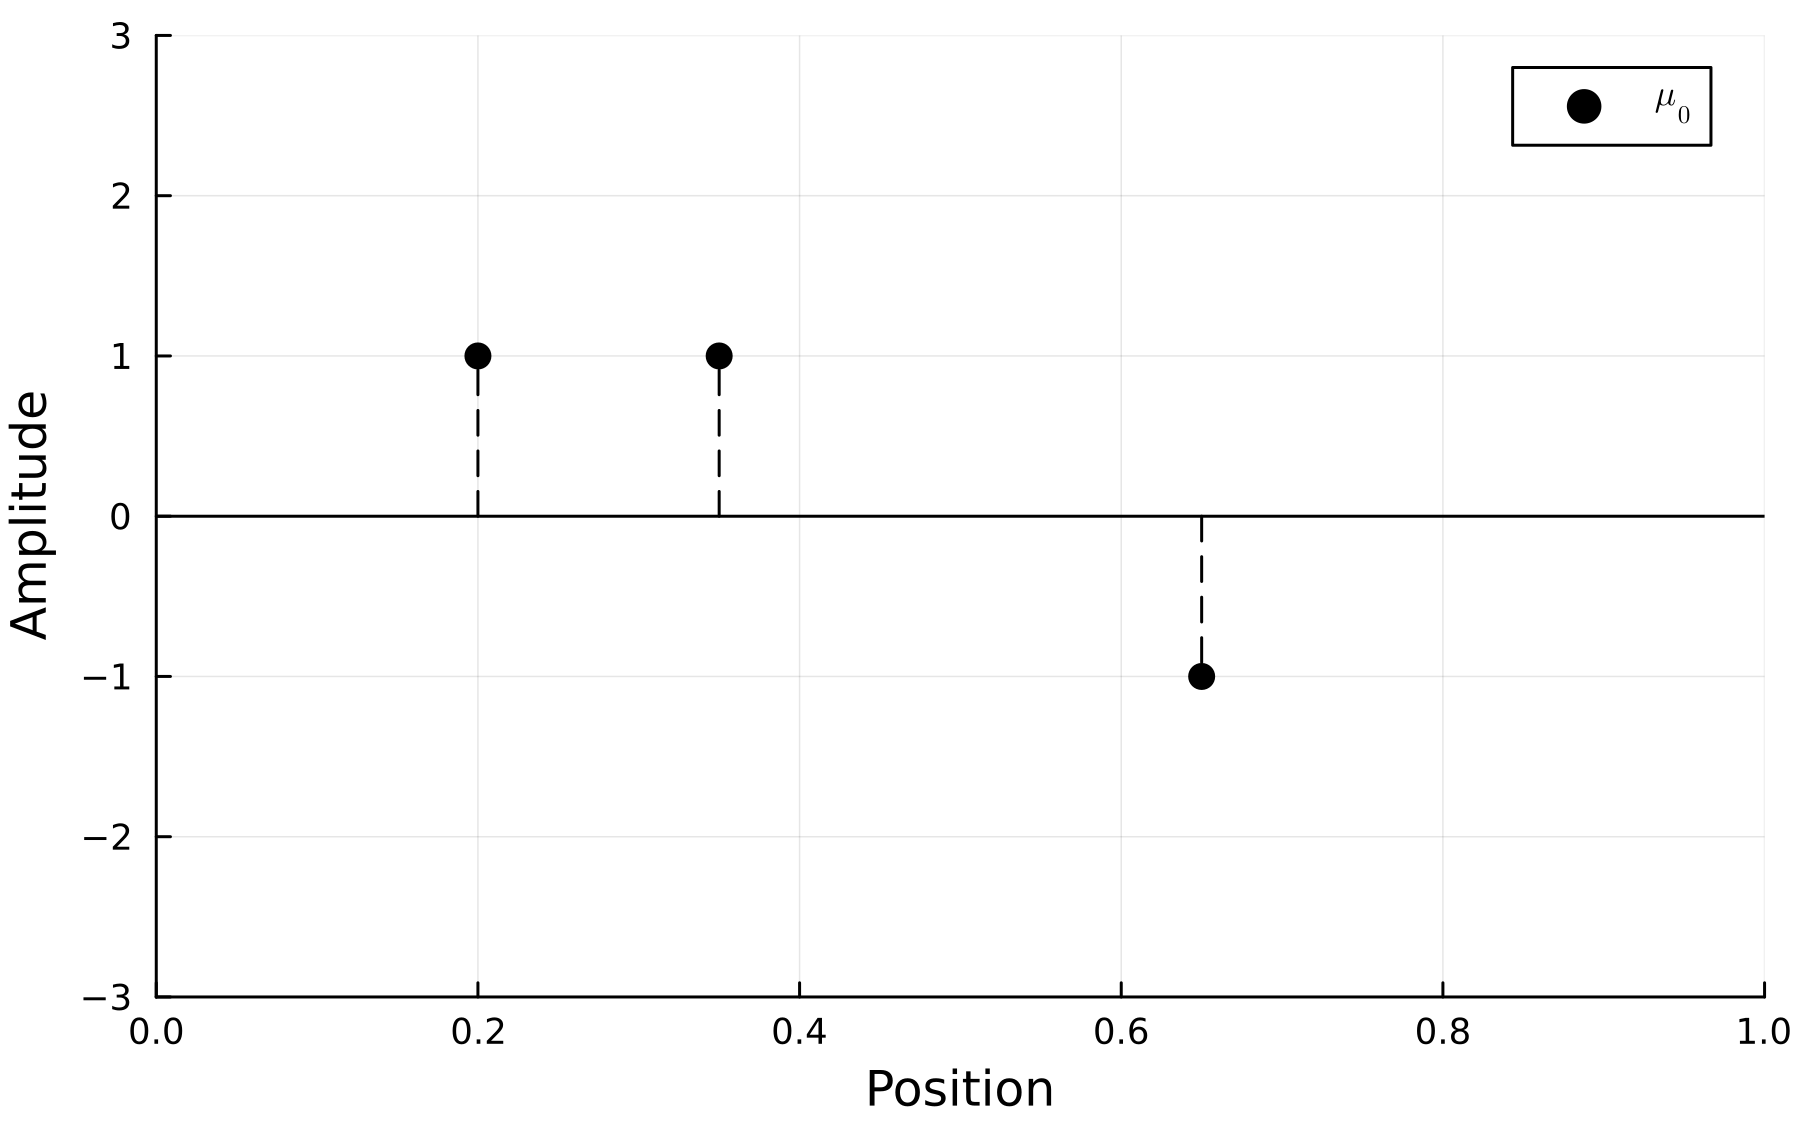

In [ ]:
# Define the plot
num_points = 1000
plt_grid = range(domain..., length=(num_points + 1))
plot_size = (400, 250) .* 1.5
plt = plot(xlims=extrema(domain), ylims=(-3, 3), xlabel="Position", ylabel="Amplitude", legend=:topright, size=plot_size, dpi=300)
hline!(plt, [0], linestyle=:solid, color=:black, label="")

plot!(plt, μ0.x, μ0.a, seriestype=:scatter, color=:black, label=L"μ_0", marker=:circle, markersize=5, markerstrokewidth=0)
for (xi, ai) in zip(μ0.x, μ0.a)
    plot!(plt, [xi, xi], [0, ai], linestyle=:dash, color=:black, label="")
end
plt

In [360]:
ops = fourier_operators_1D(fc, plt_grid)

Operators(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.3333333333333333, -4:4), var"#Φ#13"{var"#ϕ#12"{Float64, UnitRange{Int64}}}(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.3333333333333333, -4:4)), var"#adjΦ#14"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, UnitRange{Int64}}}}(0.0:0.001:1.0, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, UnitRange{Int64}}}(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.3333333333333333, -4:4))))

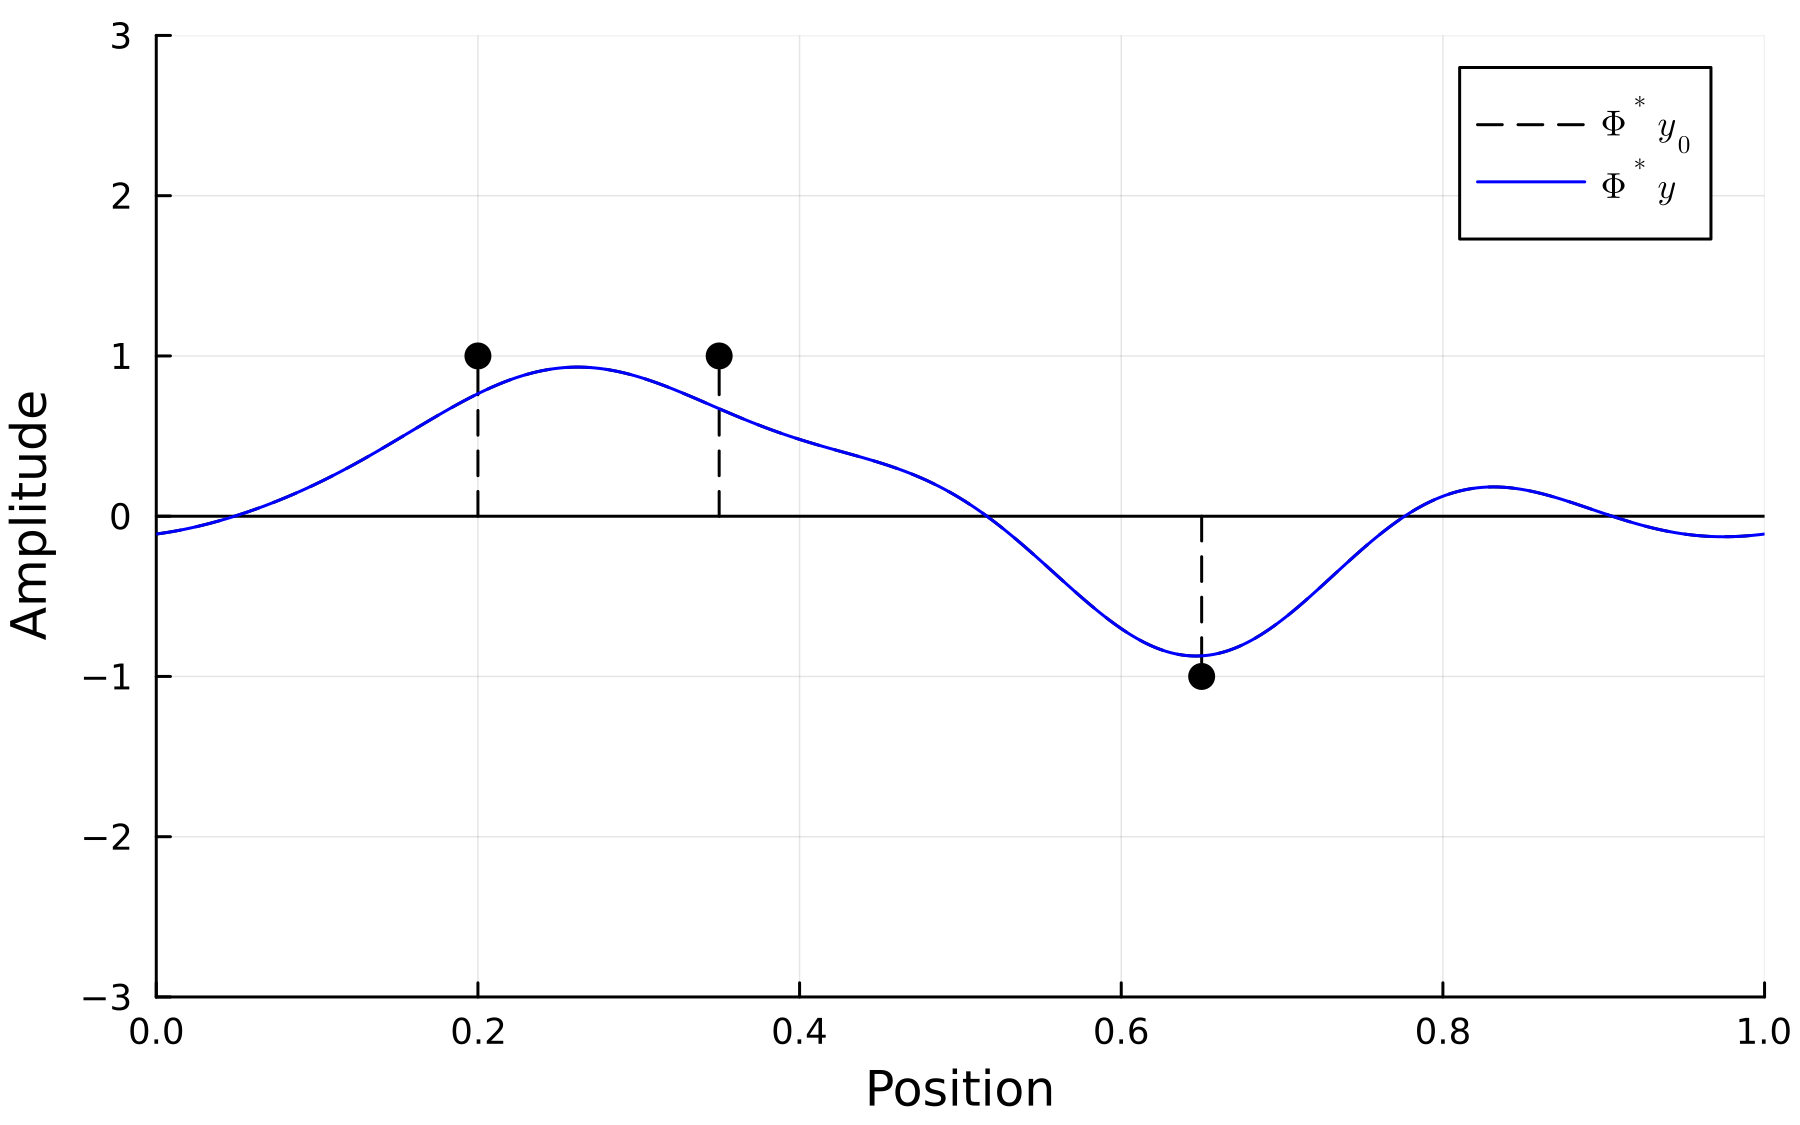

In [ ]:
# Calculate the observation y0 = Φμ0
y0 = ops.Φ(x0, a0)

# Add noise to the observation y = y0 + w
sigma = noise_level * norm(y0)
w = fftshift(fft(randn(length(y0))))
w = w / norm(w) * sigma
y = y0 + w

plt_obs = deepcopy(plt)

plot!(plt_obs, plt_grid, ops.adjΦ(y0), label=L"Φ^{\ast}y_0", color=:black, linestyle=:dash)
plot!(plt_obs, plt_grid, ops.adjΦ(y), label=L"Φ^{\ast}y", color=:blue)

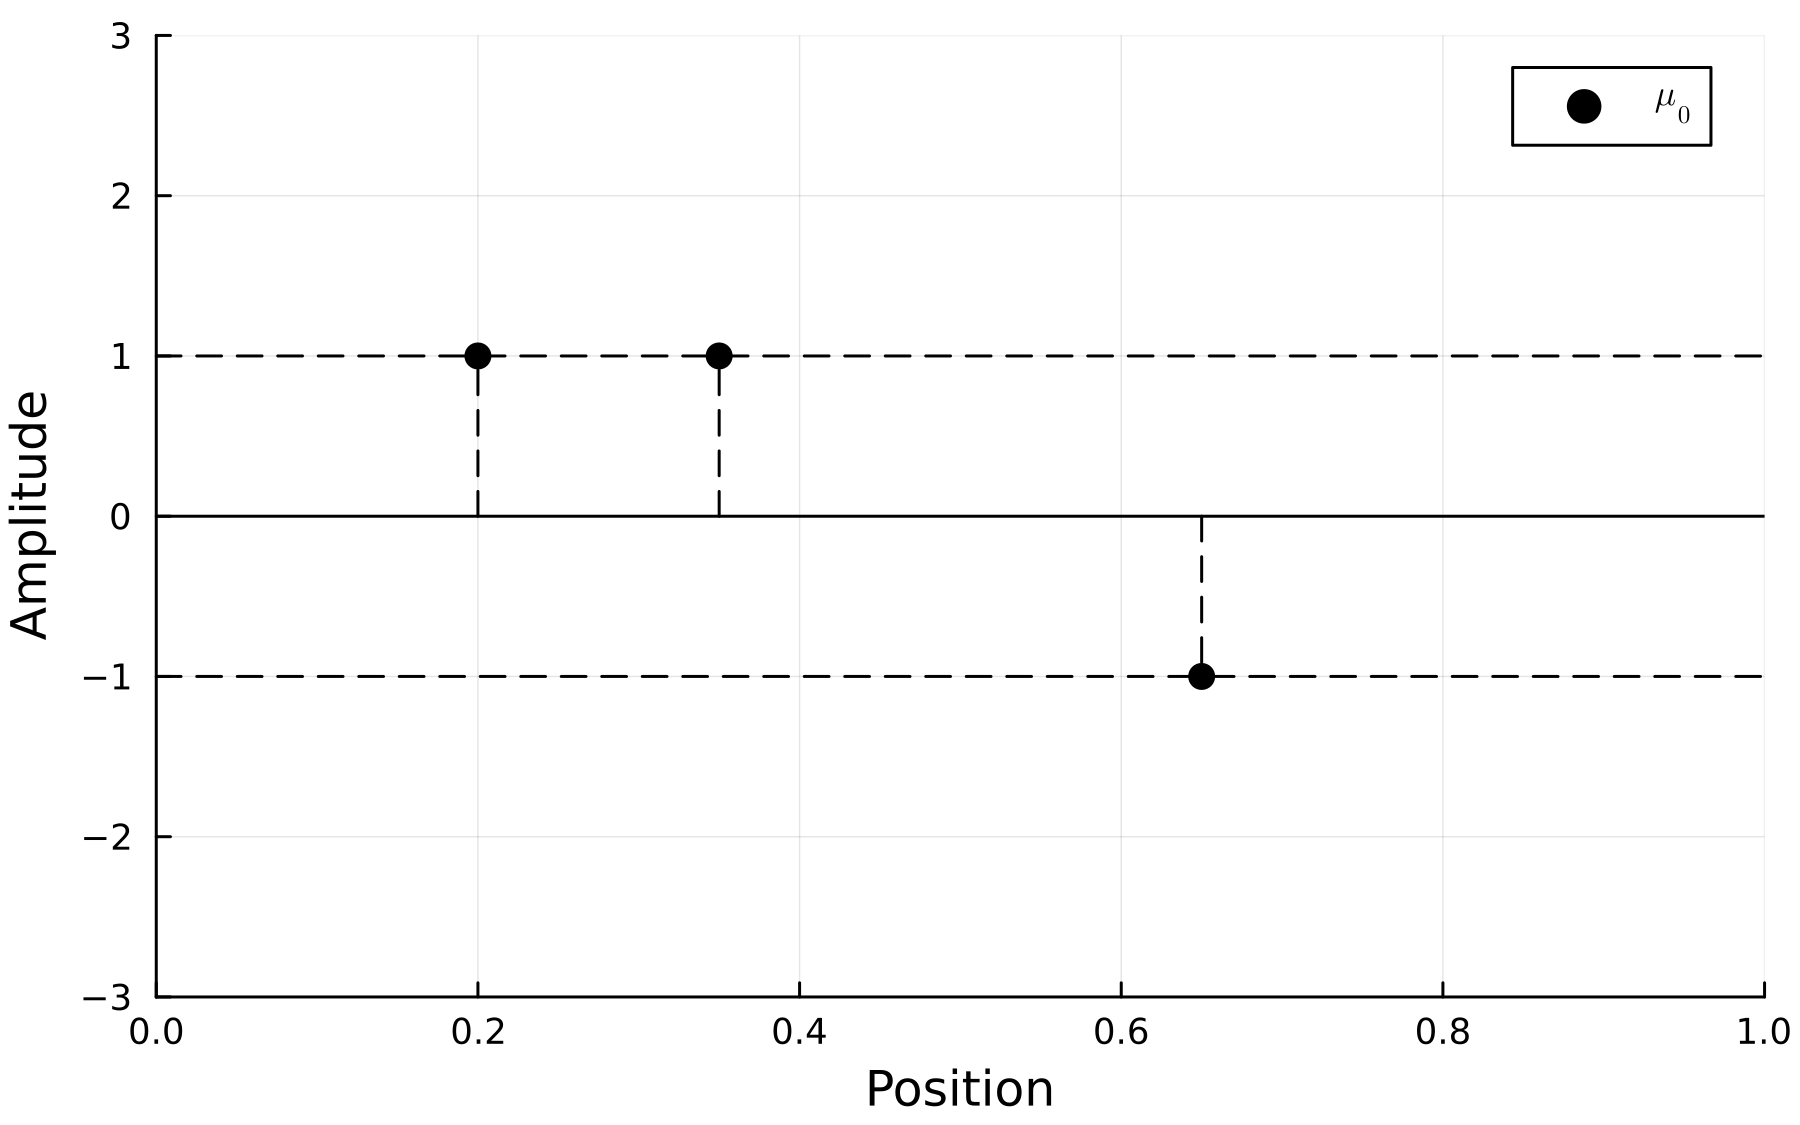

In [438]:
ηV = pre_certificate(μ0, ops)

plt_cert = deepcopy(plt)

# plot!(plt_cert, plt_grid, ηV, label=L"η_V", color=:green)
hline!(plt_cert, [1, -1], linestyle=:dash, color=:black, label="")

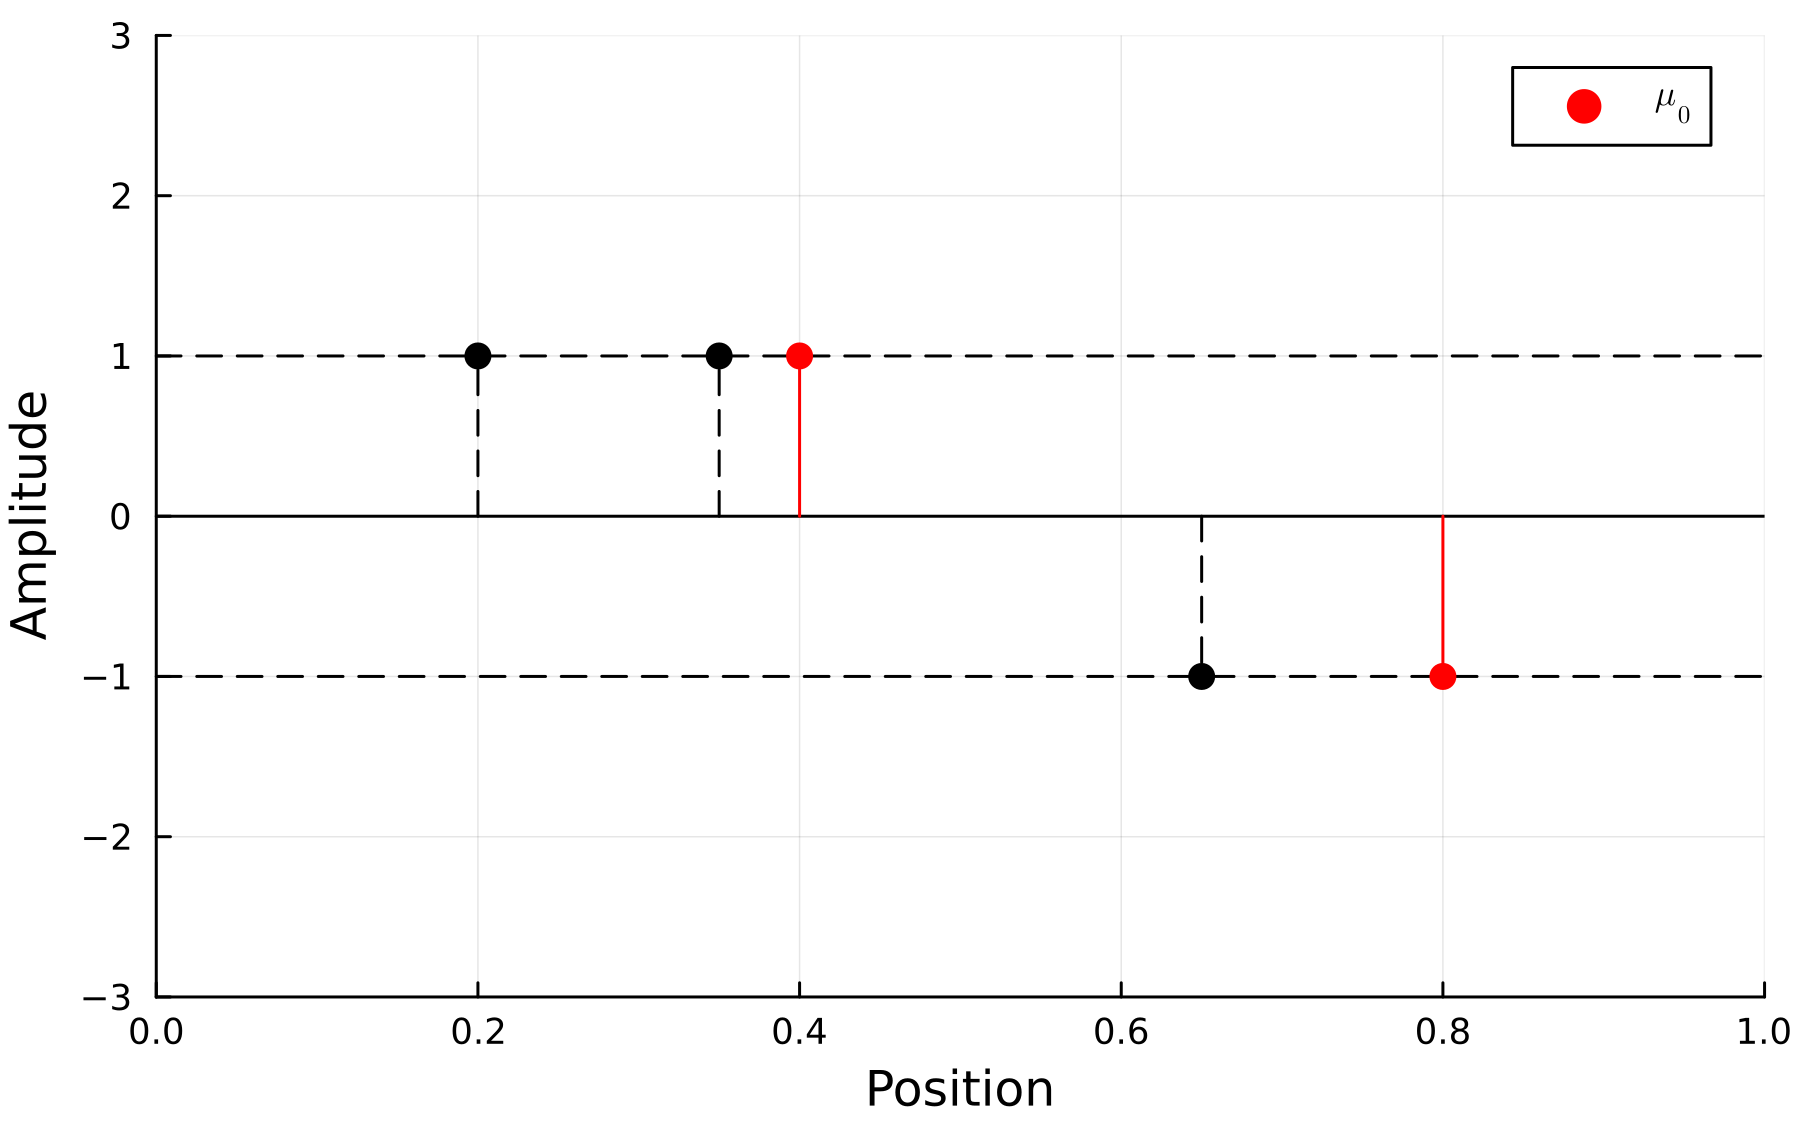

In [363]:
function plot_spikes_line!(plt, μ; label="", color=:black)
    plot!(plt, μ.x, μ.a, seriestype=:scatter, color=color, label=label, marker=:circle, markersize=5, markerstrokewidth=0)
    for (xi, ai) in zip(μ.x, μ.a)
        plot!(plt, [xi, xi], [0, ai], linestyle=:solid, color=color, label="")
    end
end

plt_test = deepcopy(plt_cert)
μ_test = DiscreteMeasure([0.4, 0.8], [1.0, -1.0])
plot_spikes_line!(plt_test, μ_test, label=L"μ_0", color=:red)
plt_test

In [ ]:
using LinearAlgebra, Optim, ProgressMeter, BenchmarkTools, LineSearches

export SFW!, BSFW!

function clamp_strict(x, lo, hi)
    if x ≤ lo
        return lo + 1e-20
    elseif x ≥ hi
        return hi - 1e-20
    else
        return x
    end
end

function clamp_strict!(x::AbstractArray, lo::AbstractArray, hi::AbstractArray)
    @inbounds for i in eachindex(x, lo, hi)
        x[i] = clamp_strict(x[i], lo[i], hi[i])
    end
end

function prune!(xvals::AbstractVector{T}, avals::AbstractVector{T}, factor::Real=1e-5) where {T<:Real}
    isempty(avals) && return

    maxval = maximum(avals)
    idx = findall(x -> abs(x) < factor * maxval, avals)
    deleteat!(xvals, idx)
    deleteat!(avals, idx)
end

function coarse_grid(domain::Vector{T}, gridsize::Int) where {T<:Real}
    range(extrema(domain)..., length=gridsize)
end

function η(
    grid::AbstractVector{<:Number},
    x::AbstractVector{T},
    a::AbstractVector{T},
    adjΦ::Function,
    Φ::Function,
    y::AbstractVector{<:Number},
    λ::Real
) where {T<:Real}
    adjΦ(y - Φ(x, a), grid=grid) / λ
end

function compute_next_spike(
    xgrid::AbstractVector{T},
    xvals::AbstractVector{T},
    avals::AbstractVector{T},
    adjΦ::Function,
    Φ::Function,
    y::AbstractVector{<:Number},
    λ::Real
) where {T<:Real}
    η_k = η(xgrid, xvals, avals, adjΦ, Φ, y, λ)
    idx = argmax(abs.(η_k))
    return xgrid[idx], abs(η_k[idx]), η_k
end

function lasso_update!(
    xnew::T,
    xvals::AbstractVector{T},
    avals::AbstractVector{T},
    M::Real,
    k::Int,
    adjΦ::Function,
    Φ::Function,
    y::AbstractVector{<:Number},
    λ::Real,
    domain::Vector{<:Real},
    amplitudes_lo::Real
) where {T<:Real}
    mfun(grid) = -0.5 * sum(abs2, η(grid, xvals, avals, adjΦ, Φ, y, λ))

    xnew = clamp_strict(xnew, domain[1], domain[2])

    result = optimize(mfun, [xnew], LBFGS(); autodiff=:forward)
    xnew = Optim.minimizer(result)[1]

    xnew = clamp_strict(xnew, domain[1], domain[2])

    anew = M * sign(η([xnew], xvals, avals, adjΦ, Φ, y, λ)[1])
    anew = clamp_strict(anew, amplitudes_lo, Inf)

    push!(xvals, xnew)
    avals .*= (1 - 2 / (k + 2))
    push!(avals, 2 / (k + 2) * anew)
end

function optimise_amplitudes!(
    xvals::AbstractVector{T},
    avals::AbstractVector{T},
    ϕ::Function,
    y::AbstractVector{<:Number},
    λ::Real,
    amplitudes_lo::Real
) where {T<:Real}
    X = real(ϕ(xvals)' * ϕ(xvals))
    Xty = real(ϕ(xvals)' * y)
    τ = 1 / norm(X)

    for _ in 1:100
        avals .-= τ * (X * avals .- Xty)
        avals .= max.(sign.(avals) .* max.(abs.(avals) .- τ * λ, 0), amplitudes_lo)
    end
end

function local_descent_BFGS!(
    xvals::AbstractVector{T},
    avals::AbstractVector{T},
    Φ::Function,
    y::AbstractVector{<:Number},
    λ::Real,
    k::Int,
    domain::AbstractVector{<:Real},
    amplitudes_lo::Real
) where {T<:Real}
    function func(xa)
        x, a = xa[1:k], xa[(k+1):end]
        λ * norm(a, 1) + 0.5 * sum(abs2, y - Φ(x, a))
    end

    xa0 = vcat(xvals, avals)
    lower_bounds = vcat(fill(domain[1], k), fill(amplitudes_lo, k))
    upper_bounds = vcat(fill(domain[2], k), fill(Inf, k))
    clamp_strict!(xa0, lower_bounds, upper_bounds)

    result = optimize(
        func,
        xa0,
        BFGS(linesearch=LineSearches.BackTracking()),
        Optim.Options(g_tol=1e-4);
        autodiff=:forward
    )
    xa_opt = Optim.minimizer(result)

    clamp_strict!(xa_opt, lower_bounds, upper_bounds)

    xvals .= xa_opt[1:k]
    avals .= xa_opt[(k+1):end]
end

"""
Solve the BLASSO problem using Sliding Frank-Wolfe (SFW) algorithm.
Handles both 1D and 2D cases.
"""
function SFW!(blasso::BLASSO, options::Dict{Symbol,<:Any}=Dict{Symbol,Any}())::BLASSO
    y, λ = blasso.y, blasso.λ
    ops = blasso.operators
    ϕ, Φ, adjΦ = ops.ϕ, ops.Φ, ops.adjΦ

    maxits = get(options, :maxits, 100)
    gridsize = get(options, :gridsize, 21)
    tol = get(options, :tol, 1.00001)
    descent = get(options, :descent, :BFGS)
    positivity = get(options, :positivity, false)
    amplitudes_lo = positivity ? 0 : -Inf

    xgrid = coarse_grid(blasso.domain, gridsize)

    xvals = blasso.dim == 1 ? Float64[] : [Float64[], Float64[]]

    M = sum(abs2.(y)) / (2 * λ)
    avals = Float64[]

    @showprogress desc = "SFW iterations: " for k in 1:maxits
        # for k in 1:maxits

        xnew, η_max, η_k = compute_next_spike(xgrid, xvals, avals, adjΦ, Φ, y, λ)

        push!(ηs, η_k)

        η_max < tol && break

        lt = @timed lasso_update!(xnew, xvals, avals, M, k, adjΦ, Φ, y, λ, blasso.domain, amplitudes_lo)

        optimise_amplitudes!(xvals, avals, ϕ, y, λ, amplitudes_lo)

        local_descent_BFGS!(xvals, avals, Φ, y, λ, k, blasso.domain, amplitudes_lo)

        prune!(xvals, avals, 0.001)

        push!(μs, deepcopy(DiscreteMeasure(xvals, avals)))
    end

    blasso.μ = blasso.dim == 1 ? DiscreteMeasure(xvals, avals) : DiscreteMeasure(collect(xvals), avals)

    return blasso
end

SFW!

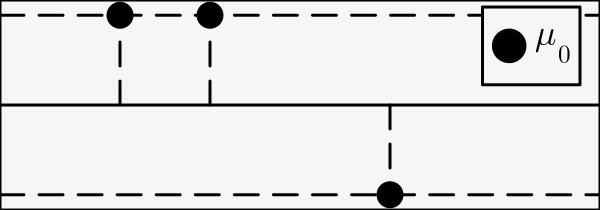

In [439]:
using Plots.Measures
plot!(plt_cert, yrange=(-1.17, 1.17), grid=:none, ticks=:none, ylabel="", xlabel="", frame=:box, margins=-2mm, size=(200, 70), bg=Colors.RGB(248 / 255, 245 / 255, 247 / 255))

## Sliding Frank-Wolfe

In [396]:
λ = 0.007

prob = BLASSO(y, ops, domain, λ)

μs = []
ηs = []

SFW!(prob, Dict(:gridsize => 41))

BLASSO(ComplexF64[0.1030056647916493 + 0.07483799609659741im, -0.2696723314583157 + 0.010082912152474005im, -0.26967233145831593 - 0.438109260099278im, 0.1030056647916492 + 0.8563635016816828im, 0.3333333333333333 + 0.0im, 0.1030056647916492 - 0.8563635016816828im, -0.26967233145831593 + 0.438109260099278im, -0.2696723314583157 - 0.010082912152474005im, 0.1030056647916493 - 0.07483799609659741im], Operators(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.3333333333333333, -4:4), var"#Φ#13"{var"#ϕ#12"{Float64, UnitRange{Int64}}}(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.3333333333333333, -4:4)), var"#adjΦ#14"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, UnitRange{Int64}}}}(0.0:0.001:1.0, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, UnitRange{Int64}}}(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.3333333333333333, -4:4)))), [0, 1], 0.007, DiscreteMeasure([0.3499324254841072, 0.6499728281848338, 0.20012525380500626], [0.98976952165

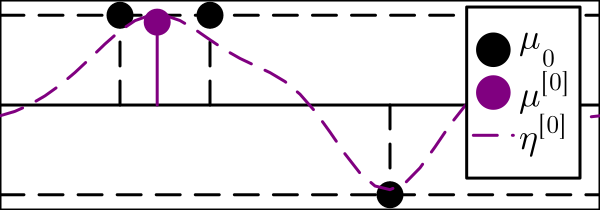

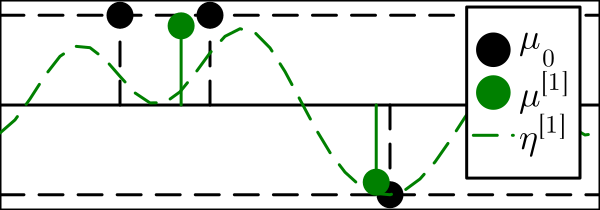

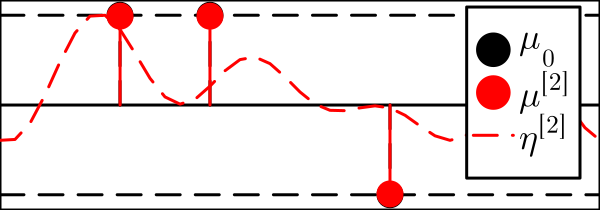

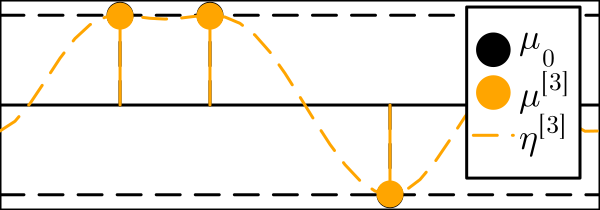

"c:\\Users\\ladis\\OneDrive - University of Warwick\\Year 4\\Super resolution\\Codes\\SparseSpikes\\figures\\SFW\\step_3.svg"

In [441]:
plt_coarse_grid = range(0, 1.0; length=41)

colours = [:purple, :green, :red, :blue, :orange]

plot!(plt_cert, bg=:white)

for k in 1:length(ηs) - 1
    plt_k = deepcopy(plt_cert)
    plot_spikes_line!(plt_k, μs[k], label=latexstring("μ^{[{", k-1, "}]}"), color=colours[k])
    plot!(plt_k, plt_coarse_grid, ηs[k] ./ maximum(abs, ηs[k]), label=latexstring("η^{[{", k-1, "}]}"), color=colours[k], linestyle=:dash) #yrange=(-maximum(abs, ηs[k]), maximum(abs, ηs[k])))
    display(plt_k)
    savefig(plt_k, "../../figures/SFW/step_$(k-1).svg")
end

plt_final = deepcopy(plt_cert)
plot_spikes_line!(plt_final, prob.μ, label=latexstring("μ^{[{", length(ηs)-1, "}]}"), color=colours[end])
plot!(plt_final, plt_coarse_grid, ηs[end], label=latexstring("η^{[{", length(ηs)-1, "}]}"), color=colours[end], linestyle=:dash)
display(plt_final)
savefig(plt_final, "../../figures/SFW/step_$(length(ηs)-1).svg")